In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import os
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import gc
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
import lightgbm as lgb
import shap

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.options.mode.chained_assignment = None


/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [2]:
path = '../input/weather-dataset-rattle-package'

In [3]:
def chunk_shapper(X,model, n = 20, verbose=True, dim = 20000):
    pos = np.sort(np.random.randint(X.shape[0], size=dim))
    X = X.iloc[pos, :].reset_index(drop = True)

    predict_fold = KFold(n)
    result = np.zeros(X.shape)
    if verbose:
        for trn_idx, val_idx in tqdm(predict_fold.split(X)):
               result[val_idx,:] = model.shap_values(X.iloc[val_idx,:])[1]
    else:
        for trn_idx, val_idx in predict_fold.split(X):
            result[val_idx,:] = model.shap_values(X.iloc[val_idx,:])[1]
    return(result,pos)


In [4]:
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df


In [5]:
def feature_engineer_pipeline(data):
    data['Date'] = pd.to_datetime(data['Date'])

    data["month"] = data['Date'].apply(lambda x : x.month)
    data["day"] = data['Date'].apply(lambda x : x.day)
    data["year"] = data['Date'].apply(lambda x : x.day)

    data['delta_temp'] = data['MinTemp'] - data['MaxTemp']
    data['delta_wind_speed'] = data['WindSpeed3pm'] - data['WindSpeed9am']
    data['delta_humidity'] = data['Humidity3pm'] - data['Humidity9am']
    data['delta_pressure'] = data['Pressure3pm'] - data['Pressure9am']
    data['delta_cloud'] = data['Cloud3pm'] - data['Cloud9am']
    data['delta_temp'] = data['Temp3pm'] - data['Temp9am']

    #add country
    
    to_drop = ['RISK_MM', 'Date']
    data = data.drop(to_drop, axis = 1)
        
    return(data)

def aggregation_pipeline(data, numeric_col):
    for col in tqdm(numeric_col):
        
        gc.collect()
        
        data[f'{col}_agg_month_loc'] = data[['month', 'Location', col]].groupby(['month', 'Location']).transform(np.nanmean)
        data[f'{col}_diff_month_loc'] = data[col] - data[f'{col}_agg_month_loc']
        
        gc.collect()
        data[f'{col}_agg_year_loc'] = data[['year', 'Location', col]].groupby(['year', 'Location']).transform(np.nanmean)
        data[f'{col}_diff_year_loc'] = data[col] - data[f'{col}_agg_year_loc']

        gc.collect()
        data[f'{col}_agg_day_loc'] = data[['day', 'Location', col]].groupby(['day', 'Location']).transform(np.nanmean)
        data[f'{col}_diff_day_loc'] = data[col] - data[f'{col}_agg_day_loc']
        
    return data

def remover_pipeline(data, categoric_column, numeric_column):
    
    to_erase = ['RainToday']
    data = data.drop('RainToday', axis = 1)
    
    categoric_column = [x for x in categoric_column if x not in to_erase]
    numeric_column = [x for x in numeric_column if x not in to_erase]

    return data, categoric_column, numeric_column
    
def loader(path = path):
    data = pd.read_csv(os.path.join(path, 'weatherAUS.csv'))
    data = reduce_mem_usage_sd(data)
    
    data = feature_engineer_pipeline(data)
    data = reduce_mem_usage_sd(data)

    categoric_col = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'month', 'day', 'year', 'RainTomorrow']
    numeric_col = [x for x in data.columns if x not in categoric_col]
    
    data[categoric_col] = data[categoric_col].astype(str, copy = True)
    
    data, categoric_col, numeric_col = remover_pipeline(data, categoric_col, numeric_col)
    data = aggregation_pipeline(data, numeric_col)
    
    col_strat = ['RainTomorrow', 'Location']
    strat = data[col_strat].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    le = LabelEncoder()
    strat = le.fit_transform(strat).astype(np.int16)

    assert collections.Counter(strat).most_common()[-1][1] > 15 
    
    for col in categoric_col:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col]).astype(np.int16)
    
    categoric_col = [x for x in categoric_col if x != 'RainTomorrow']

    data = reduce_mem_usage_sd(data)

    return data, numeric_col, categoric_col, strat



def split_pipeline(data, strat):
           
    train, test, train_strat, _ = train_test_split(data, strat, test_size = 0.33, random_state = 12345, shuffle = True, stratify = strat)

    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    
    y_train, y_test = train.pop('RainTomorrow').values, test.pop('RainTomorrow').values

    return(train, test, y_train, y_test, train_strat)

In [6]:
data, numeric_col, categoric_col, strat = loader()


Mem. usage decreased from 76.79 Mb to 65.67 Mb (14.5% reduction)



Mem. usage decreased from 61.19 Mb to 58.35 Mb (4.7% reduction)



Mem. usage decreased from 62.92 Mb to 61.84 Mb (1.7% reduction)


In [7]:
df_train, df_test, y_train, y_test, train_strat = split_pipeline(data, strat)
gc.collect()

26

In [8]:
seed = 1
params = {
                    'objective': 'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'learning_rate':0.05,
                    'colsample_bytree': 0.8,
#                     'lambda_l1': 2,
#                     'lambda_l2': 2,
                    'max_depth': -1,
                    'num_leaves': 2**8,
                    'subsample': 0.75,
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                    'n_jobs':-1,
                    'importance_type':'gain',
}


In [9]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

pred = np.zeros(df_train.shape[0])
pred_test = np.zeros(df_test.shape[0])

shap_matrix = np.zeros(df_train.shape)

score = 0

model5 =[]

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]
        
        model = lgb.train(
            params,
            lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
            3500, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
            categorical_feature = categoric_col,
            valid_names ='validation',
            verbose_eval = 50, early_stopping_rounds = 50
        )
    
        temp_y = model.predict(valid_x)
                
        pred[val_idx] = temp_y
        pred_test += model.predict(df_test)/n_fold

        score += roc_auc_score(valid_y, temp_y)/n_fold
        
        print('\nFold: {}; Auc: {:.3f}\n'.format(fold_, roc_auc_score(valid_y, temp_y)))
        
        model5.append(model)
        
print('CV - Auc : {}\n'.format(score))

test_score = roc_auc_score(y_test, pred_test)
print('Test - Auc : {}\n'.format(test_score))


Training until validation scores don't improve for 50 rounds
[50]	validation's auc: 0.90264
[100]	validation's auc: 0.907012
[150]	validation's auc: 0.909122
[200]	validation's auc: 0.909872
[250]	validation's auc: 0.909951
[300]	validation's auc: 0.910083
[350]	validation's auc: 0.910307
[400]	validation's auc: 0.910526
[450]	validation's auc: 0.910726
[500]	validation's auc: 0.910963
[550]	validation's auc: 0.911186
[600]	validation's auc: 0.911273
Early stopping, best iteration is:
[569]	validation's auc: 0.911307

Fold: 0; Auc: 0.911

Training until validation scores don't improve for 50 rounds
[50]	validation's auc: 0.899897
[100]	validation's auc: 0.905061
[150]	validation's auc: 0.90708
[200]	validation's auc: 0.907898
[250]	validation's auc: 0.908211
[300]	validation's auc: 0.908634
[350]	validation's auc: 0.908615
Early stopping, best iteration is:
[313]	validation's auc: 0.908732

Fold: 1; Auc: 0.909

Training until validation scores don't improve for 50 rounds
[50]	validatio

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

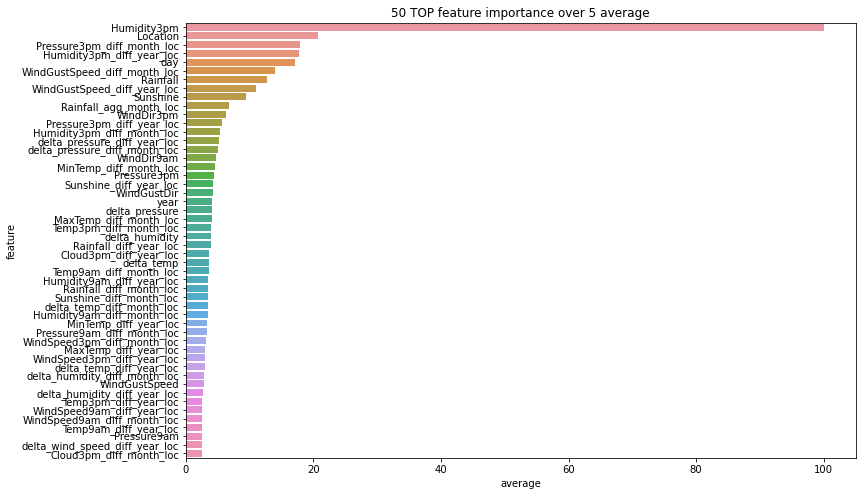

In [10]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')

    
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))
